# Image properties detection using Amazon Rekognition

***
This notebook provides a walkthrough of [object detection API](https://docs.aws.amazon.com/rekognition/latest/dg/labels.html) in Amazon Rekognition to identify objects.
***

# Initialize stuff

In [4]:
# Initialise Notebook
import boto3
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont
import time
import os

import sagemaker

# variables
data_bucket = sagemaker.Session().default_bucket()
role = sagemaker.get_execution_role()
awsRegion = boto3.session.Session().region_name

s3 = boto3.client('s3')
rekognition = boto3.client('rekognition')


print(f"SageMaker role is: {role}\nDefault SageMaker Bucket: s3://{data_bucket}")

SageMaker role is: arn:aws:iam::122702569249:role/service-role/AmazonSageMaker-ExecutionRole-20220815T203517
Default SageMaker Bucket: s3://sagemaker-us-east-1-122702569249


# Detect objects in image
***

![image-properties-detection-sample](../datasets/green_car.jpeg)

In [6]:
image_s3_key = 'content-moderation-im/image-moderation/green_car.jpeg'
s3.upload_file('../datasets/green_car.jpeg', data_bucket, image_s3_key)

#### Call Rekognition to detect objects in the image

In [8]:
# Call Amazon Rekognition to detect objects in the image
# https://docs.aws.amazon.com/rekognition/latest/dg/API_DetectLabels.html

detectLabelsResponse = rekognition.detect_labels(
    Image={
        'S3Object': {
            'Bucket': data_bucket,
            'Name': image_s3_key,
        }
    }
)

#### Review the raw JSON reponse from Rekognition

In [9]:
# Show JSON response returned by Rekognition Labels API (Object Detection)
# In the JSON response below, you will see Label, detected instances, confidence score and additional information.

display(detectLabelsResponse)

{'Labels': [{'Name': 'Car',
   'Confidence': 99.98550415039062,
   'Instances': [{'BoundingBox': {'Width': 0.6112807989120483,
      'Height': 0.7059382796287537,
      'Left': 0.3115743398666382,
      'Top': 0.2101004421710968},
     'Confidence': 99.72306060791016}],
   'Parents': [{'Name': 'Transportation'}, {'Name': 'Vehicle'}],
   'Aliases': [{'Name': 'Automobile'}],
   'Categories': [{'Name': 'Vehicles and Automotive'}]},
  {'Name': 'Coupe',
   'Confidence': 99.98550415039062,
   'Instances': [],
   'Parents': [{'Name': 'Car'},
    {'Name': 'Sports Car'},
    {'Name': 'Transportation'},
    {'Name': 'Vehicle'}],
   'Aliases': [],
   'Categories': [{'Name': 'Vehicles and Automotive'}]},
  {'Name': 'Sports Car',
   'Confidence': 99.98550415039062,
   'Instances': [],
   'Parents': [{'Name': 'Car'},
    {'Name': 'Transportation'},
    {'Name': 'Vehicle'}],
   'Aliases': [],
   'Categories': [{'Name': 'Vehicles and Automotive'}]},
  {'Name': 'Transportation',
   'Confidence': 99.985

#### Display list of detected unsafe objects}

In [ ]:
flaggedObjects = ["Car"]

for label in detectLabelsResponse["Labels"]:
    if(label["Name"] in flaggedObjects):
        print("Detected unsafe object:")
        print("- {} (Confidence: {})".format(label["Name"], label["Confidence"]))
        print("  - Parents: {}".format(label["Parents"]))

#### The code snippets below demonstrate how to use an open-source computer vision library, Pillow, to draw bounding box overlays on images. This allows you to visualize the location of an object in an image by highlighting the area with a box.

In [ ]:
# Define a function that will display image with bounded boxes around recognized objects
# We will call this function in next step
  
def drawBoundingBoxes (sourceImage, boxes):
    # blue, green, red, grey
    colors = ((255,255,255),(255,255,255),(76,182,252),(52,194,123))
    
    # Download image locally
    #imageLocation = tempFolder+os.path.basename(sourceImage)
    imageLocation = sourceImage
    #s3.download_file(bucketName, sourceImage, imageLocation)

    # Draws BB on Image
    bbImage = Image.open(imageLocation)
    draw = ImageDraw.Draw(bbImage)
    width, height = bbImage.size
    col = 0
    maxcol = len(colors)
    line= 3
    for box in boxes:
        x1 = int(box[1]['Left'] * width)
        y1 = int(box[1]['Top'] * height)
        x2 = int(box[1]['Left'] * width + box[1]['Width'] * width)
        y2 = int(box[1]['Top'] * height + box[1]['Height']  * height)
        
        draw.text((x1,y1),box[0],colors[col])
        for l in range(line):
            draw.rectangle((x1-l,y1-l,x2+l,y2+l),outline=colors[col])
        col = (col+1)%maxcol
    
    imageFormat = "PNG"
    ext = sourceImage.lower()
    if(ext.endswith('jpg') or ext.endswith('jpeg')):
        imageFormat = 'JPEG'

    bbImage.save(imageLocation,format=imageFormat)

    display(bbImage)

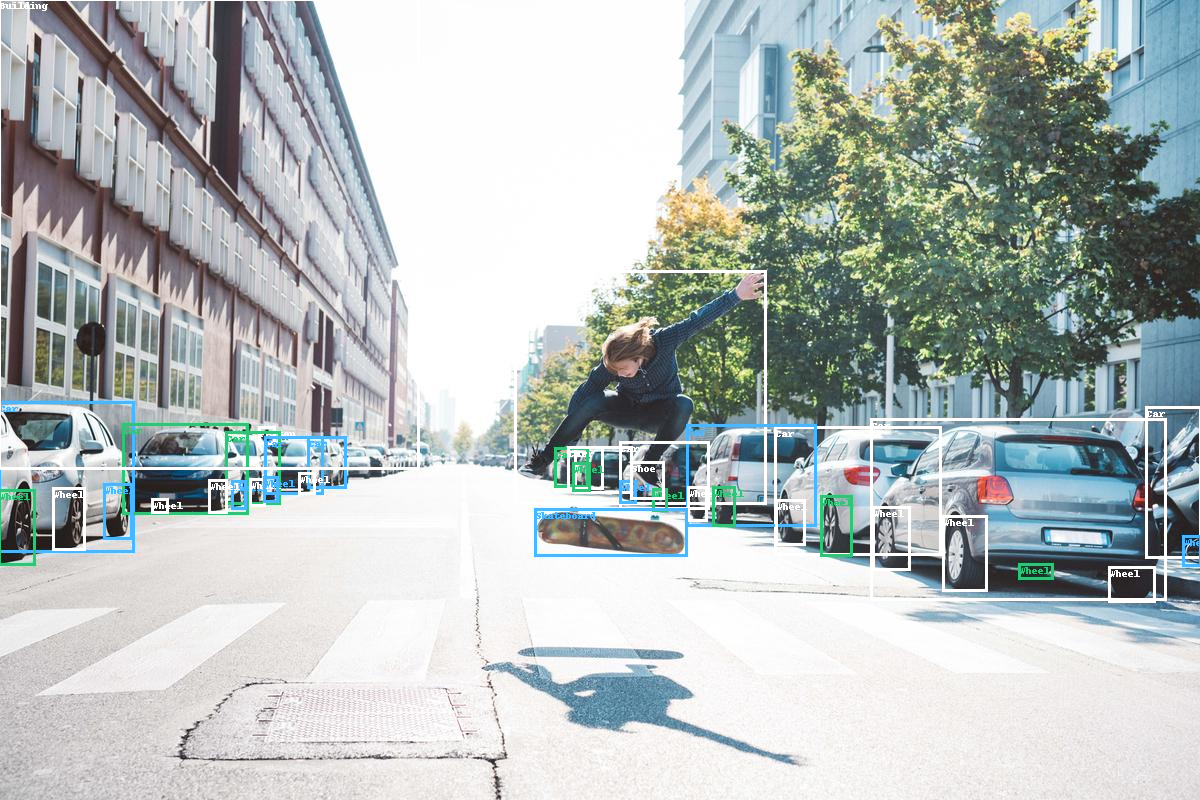

In [52]:
# Show image and bounded boxes around detected objects
boxes = []
objects = detectLabelsResponse['Labels']
for obj in objects:
    for einstance in obj["Instances"]:
        boxes.append ((obj['Name'], einstance['BoundingBox']))
    
drawBoundingBoxes("../datasets/cars.jpg", boxes)


### Learn more about building an end to end worker safety app
To learn on how to build an end to end worker safety app, learn more at https://github.com/aws-samples/aws-deeplens-worker-safety-project

***
### References
- https://docs.aws.amazon.com/rekognition/latest/dg/API_DetectLabels.html
- https://docs.aws.amazon.com/rekognition/latest/dg/API_StartLabelDetection.html
- https://docs.aws.amazon.com/rekognition/latest/dg/API_GetLabelDetection.html

***

You have successfully used Amazon Rekognition to identify specific objects in images and videos. In the next module,nyou will learn how to recognize explicit, suggestive or violent content in the images and videos.